In [1]:
from typing import *
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

base_dir = "/".join(os.getcwd().split("/")[:-1])

In [2]:
def naive_monte_carlo_cdf(
        mean: tf.Tensor,
        cov: tf.Tensor,
        lower: tf.Tensor,
        upper: tf.Tensor,
        num_samples: int,
    ):
    
    normal = tfp.distributions.MultivariateNormalFullCovariance(
        loc=mean,
        covariance_matrix=cov,
    )
    
    samples = normal.sample(sample_shape=[num_samples])
    
    upper = tf.tile(upper[None, :], [num_samples, 1])
    lower = tf.tile(lower[None, :], [num_samples, 1])
    
    ge = tf.cast(tf.math.greater_equal(samples, lower), dtype=tf.float32)
    ge = tf.reduce_prod(ge, axis=-1)
    
    le = tf.cast(tf.math.less_equal(samples, upper), dtype=tf.float32)
    le = tf.reduce_prod(le, axis=-1)
    
    indicator = tf.reduce_prod([ge, le], axis=0)
    
    return indicator

In [8]:
def update_add(
        tensor: tf.Tensor,
        index: List[int],
        update: tf.Tensor,
    ):
    
    index = tf.convert_to_tensor([index])
    update = tf.convert_to_tensor([update])
    
    index = tf.convert_to_tensor(index)
    updated = tf.tensor_scatter_nd_add(
        tensor=tensor,
        indices=index,
        updates=update,
    )
    
    return updated


def vector_dot(
        a: tf.Tensor,
        b: tf.Tensor,
    ):
    
    return tf.reduce_sum(a*b)


@tf.function(jit_compile=True)
def single_sample_cdf(
        mean: tf.Tensor,
        cov: tf.Tensor,
        lower: tf.Tensor,
        upper: tf.Tensor,
        samples: tf.Tensor,
    ):
    
    # Identify data type to use for all calculations
    dtype = mean.dtype
    
    # Dimension of the integral
    D = mean.shape[-1]
    
    # Rename samples and limits for brevity
    w = samples
    a = lower
    b = upper
    
    # Compute cholesky of the covariance matrix
    C = tf.linalg.cholesky(cov)
    
    # Initialise transformation variables
    d = tf.zeros_like(mean)
    e = tf.zeros_like(mean)
    f = tf.zeros_like(mean)
    y = tf.zeros_like(mean)
    
    # Initialise standard normal for computing CDFs
    normal = tfp.distributions.Normal(
        loc=tf.zeros(shape=(), dtype=dtype),
        scale=tf.ones(shape=(), dtype=dtype),
    )
    Phi = lambda x: normal.cdf(x)
    iPhi = lambda x: normal.quantile(x)
    
    # Compute transformation variables at the first step
    d = update_add(d, [0], Phi(a[0] / C[0, 0]))
    e = update_add(e, [0], Phi(b[0] / C[0, 0]))
    f = update_add(f, [0], e[0] - d[0])
    
    for i in tf.range(1, D):
        
        # Update y[i-1]
        y = update_add(y, [i-1], iPhi(d[i-1] + w[i-1] * (e[i-1] - d[i-1])))
        
        # Update d[i-1] and e[i-1]
        d = update_add(d, [i], Phi((a[i] - vector_dot(C[i, :i], y[:i])) / C[i, i]))
        e = update_add(e, [i], Phi((b[i] - vector_dot(C[i, :i], y[:i])) / C[i, i]))
        f = update_add(f, [i], (e[i] - d[i]) * f[i-1])
        
    return f[-1]

In [112]:
# Set random seed
tf.random.set_seed(4)

# Set default data type
dtype = tf.float32

# Number of samples and dimension of Gaussian
S = 100
D = 5

# Set up the mean and covariance
mean = tf.zeros(shape=(D,), dtype=dtype)
rand = tf.random.uniform((D, D), dtype=dtype)
cov = tf.matmul(rand, rand, transpose_b=True) + tf.eye(D, dtype=dtype)

# Set up lower and upper integration limits
lower = - 1e-1 * tf.random.uniform((D,), dtype=dtype)
upper = 1e-1 * tf.random.uniform((D,), dtype=dtype)

# Draw samples to use within the MC estiamate
samples = tf.random.uniform(shape=(S, D))

# Equally well, you can use Sobol sequences by replacing the line above with
# samples = tf.math.sobol_sample(dim=D, num_results=S)

_single_sample_cdf = lambda x: single_sample_cdf(mean, cov, lower, upper, x)

CDF: 0.000000015 +/- 0.000000000


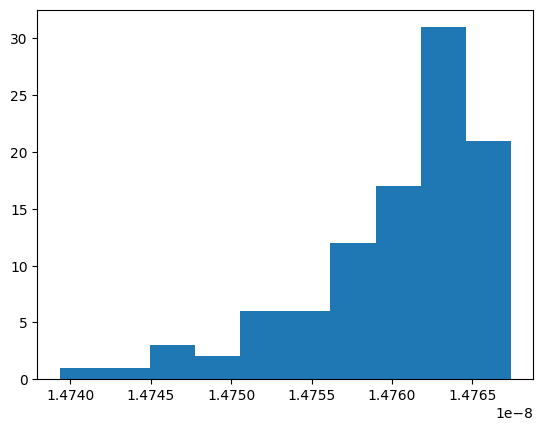

In [113]:
cdf = tf.map_fn(
    _single_sample_cdf,
    samples,
)

print(f"CDF: {tf.reduce_mean(cdf):.9f} +/- {2*tf.math.reduce_std(cdf)/S**0.5:.9f}")

plt.hist(cdf)
plt.show()

In [114]:
num_samples = 100000

naive_cdf = naive_monte_carlo_cdf(
    mean=mean,
    cov=cov,
    lower=lower,
    upper=upper,
    num_samples=num_samples,
)

tf.reduce_mean(naive_cdf), 2*tf.math.reduce_std(naive_cdf)/num_samples**0.5

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)